In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [501]:
train_df = pd.read_csv('./data/train.csv', encoding='utf-8')
building_info = pd.read_csv('./data/building_info.csv', encoding='utf-8')
test_df = pd.read_csv('./data/test.csv', encoding='utf-8')

In [502]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [503]:
test_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [504]:
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [505]:
len(train_df), len(test_df)

(204000, 16800)

In [506]:
# 시각화 인코딩 오류 방지 영어로 변환

train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train_df.drop('num_date_time', axis = 1, inplace=True)

test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_df.drop('num_date_time', axis = 1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)
train_df = pd.merge(train_df, building_info, on='building_number', how='left')
test_df = pd.merge(test_df, building_info, on='building_number', how='left')

In [507]:
train_df.isna().sum()

building_number              0
date_time                    0
temperature                  0
rainfall                160069
windspeed                   19
humidity                     9
sunshine                 75182
solar_radiation          87913
power_consumption            0
building_type                0
total_area                   0
cooling_area                 0
solar_power_capacity         0
ess_capacity                 0
pcs_capacity                 0
dtype: int64

# 1. 풍속, 습도 결측치 행 제거 (풍속 0인 경우 결측치인지? -> 아님 (기상청 관측 기준 '무풍'일 경우 0) 
무풍 : 평균 풍속이 1kts 미만인 경우

In [508]:
train_df.dropna(subset=['windspeed', 'humidity'], inplace=True)

In [509]:
train_df.isna().sum()

building_number              0
date_time                    0
temperature                  0
rainfall                160051
windspeed                    0
humidity                     0
sunshine                 75172
solar_radiation          87899
power_consumption            0
building_type                0
total_area                   0
cooling_area                 0
solar_power_capacity         0
ess_capacity                 0
pcs_capacity                 0
dtype: int64

# 2. 강수량, 일조, 일사 결측치 처리 방법 고안해볼 것

In [510]:
train_df['date_time'] = pd.to_datetime(train_df['date_time'], format='%Y%m%d %H')

# date time feature 생성
train_df['hour'] = train_df['date_time'].dt.hour
train_df['day'] = train_df['date_time'].dt.day
train_df['month'] = train_df['date_time'].dt.month

In [511]:
test_df['date_time'] = pd.to_datetime(test_df['date_time'], format='%Y%m%d %H')

# date time feature 생성
test_df['hour'] = test_df['date_time'].dt.hour
test_df['day'] = test_df['date_time'].dt.day
test_df['month'] = test_df['date_time'].dt.month

In [512]:
# train_df['month_day'] = train_df['month'].astype(str) + train_df['day'].astype(str)

# plt.figure(figsize=(10, 6))
# sns.lineplot(x=train_df['month_day'], y=train_df['rainfall'])
# plt.title('Rainfall by Day')
# plt.xlabel('Day')
# plt.ylabel('Rainfall')
# plt.show()

In [513]:
test_df.isna().sum()

building_number         0
date_time               0
temperature             0
rainfall                0
windspeed               0
humidity                0
building_type           0
total_area              0
cooling_area            0
solar_power_capacity    0
ess_capacity            0
pcs_capacity            0
hour                    0
day                     0
month                   0
dtype: int64

In [514]:
building_info.isna().sum()

building_number         0
building_type           0
total_area              0
cooling_area            0
solar_power_capacity    0
ess_capacity            0
pcs_capacity            0
dtype: int64

# 강수량, 일사, 일조 feature 삭제

In [515]:
train_df = train_df.drop(['rainfall','sunshine', 'solar_radiation'], axis=1)
test_df = test_df.drop(['rainfall'], axis=1)

In [516]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203981 entries, 0 to 203999
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   building_number       203981 non-null  int64         
 1   date_time             203981 non-null  datetime64[ns]
 2   temperature           203981 non-null  float64       
 3   windspeed             203981 non-null  float64       
 4   humidity              203981 non-null  float64       
 5   power_consumption     203981 non-null  float64       
 6   building_type         203981 non-null  object        
 7   total_area            203981 non-null  float64       
 8   cooling_area          203981 non-null  float64       
 9   solar_power_capacity  203981 non-null  object        
 10  ess_capacity          203981 non-null  object        
 11  pcs_capacity          203981 non-null  object        
 12  hour                  203981 non-null  int64         
 13 

In [517]:
print(len(train_df[train_df['solar_power_capacity'] == '-']))
print(len(train_df[train_df['ess_capacity'] == '-']))
print(len(train_df[train_df['pcs_capacity'] == '-']))

130547
193781
193781


In [518]:
print(len(test_df[test_df['solar_power_capacity'] == '-']))
print(len(test_df[test_df['ess_capacity'] == '-']))
print(len(test_df[test_df['pcs_capacity'] == '-']))

10752
15960
15960


In [519]:
train_df = train_df.replace('-', '0')
test_df = test_df.replace('-', '0')
train_df['solar_power_capacity'] = train_df['solar_power_capacity'].astype('float64')
train_df['ess_capacity'] = train_df['ess_capacity'].astype('float64')
train_df['pcs_capacity'] = train_df['pcs_capacity'].astype('float64')
test_df['solar_power_capacity'] = test_df['solar_power_capacity'].astype('float64')
test_df['ess_capacity'] = test_df['ess_capacity'].astype('float64')
test_df['pcs_capacity'] = test_df['pcs_capacity'].astype('float64')

In [520]:
train_df.head()

,building_number,date_time,temperature,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,hour,day,month
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,0,1,6
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,1,1,6
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,2,1,6
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,3,1,6
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,4,1,6


In [521]:
train_df.describe()

,building_number,temperature,windspeed,humidity,power_consumption,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,hour,day,month
count,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,2.039810e+05,2.039810e+05,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000
mean,50.498787,25.543328,2.134031,78.716354,2451.062288,2.609000e+05,1.864146e+05,35.681104,86.569063,31.002888,11.499993,14.835715,6.929386
std,28.865541,3.779281,1.358109,15.080294,2440.727607,1.273608e+06,1.085223e+06,89.700345,431.236619,146.085601,6.922397,8.446227,0.793928
min,1.000000,10.100000,0.000000,13.000000,0.000000,5.578400e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000
25%,25.000000,23.400000,1.200000,69.000000,1085.760000,6.137547e+04,2.039700e+04,0.000000,0.000000,0.000000,5.000000,8.000000,6.000000
50%,50.000000,25.700000,2.000000,81.000000,1766.340000,9.331400e+04,5.606000e+04,0.000000,0.000000,0.000000,12.000000,15.000000,7.000000
75%,75.000000,28.100000,2.800000,91.000000,2970.000000,1.877370e+05,9.960387e+04,35.000000,0.000000,0.000000,18.000000,22.000000,8.000000
max,100.000000,37.100000,13.300000,100.000000,25488.400000,1.287288e+07,1.094194e+07,621.000000,3100.000000,1000.000000,23.000000,31.000000,8.000000


In [522]:
print(len(train_df[train_df['total_area']==0]))
print(len(train_df[train_df['cooling_area']==0]))

0
6120


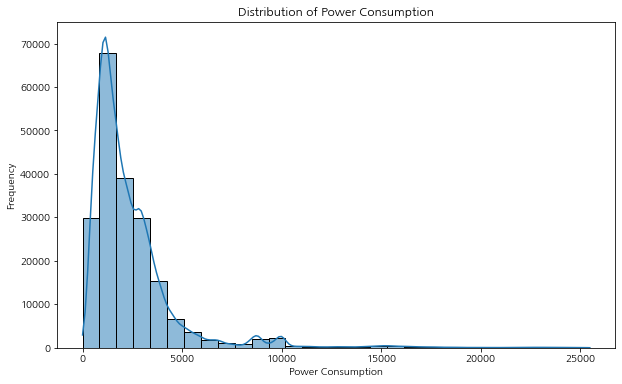

In [250]:
# # histogram 생성
# plt.figure(figsize=(10, 6))
# sns.histplot(train_df['power_consumption'], bins=30, kde=True)
# plt.title('Distribution of Power Consumption')
# plt.xlabel('Power Consumption')
# plt.ylabel('Frequency')
# plt.show()

C:\Users\magne\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\magne\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\magne\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='power_consumption', ylabel='Density'>

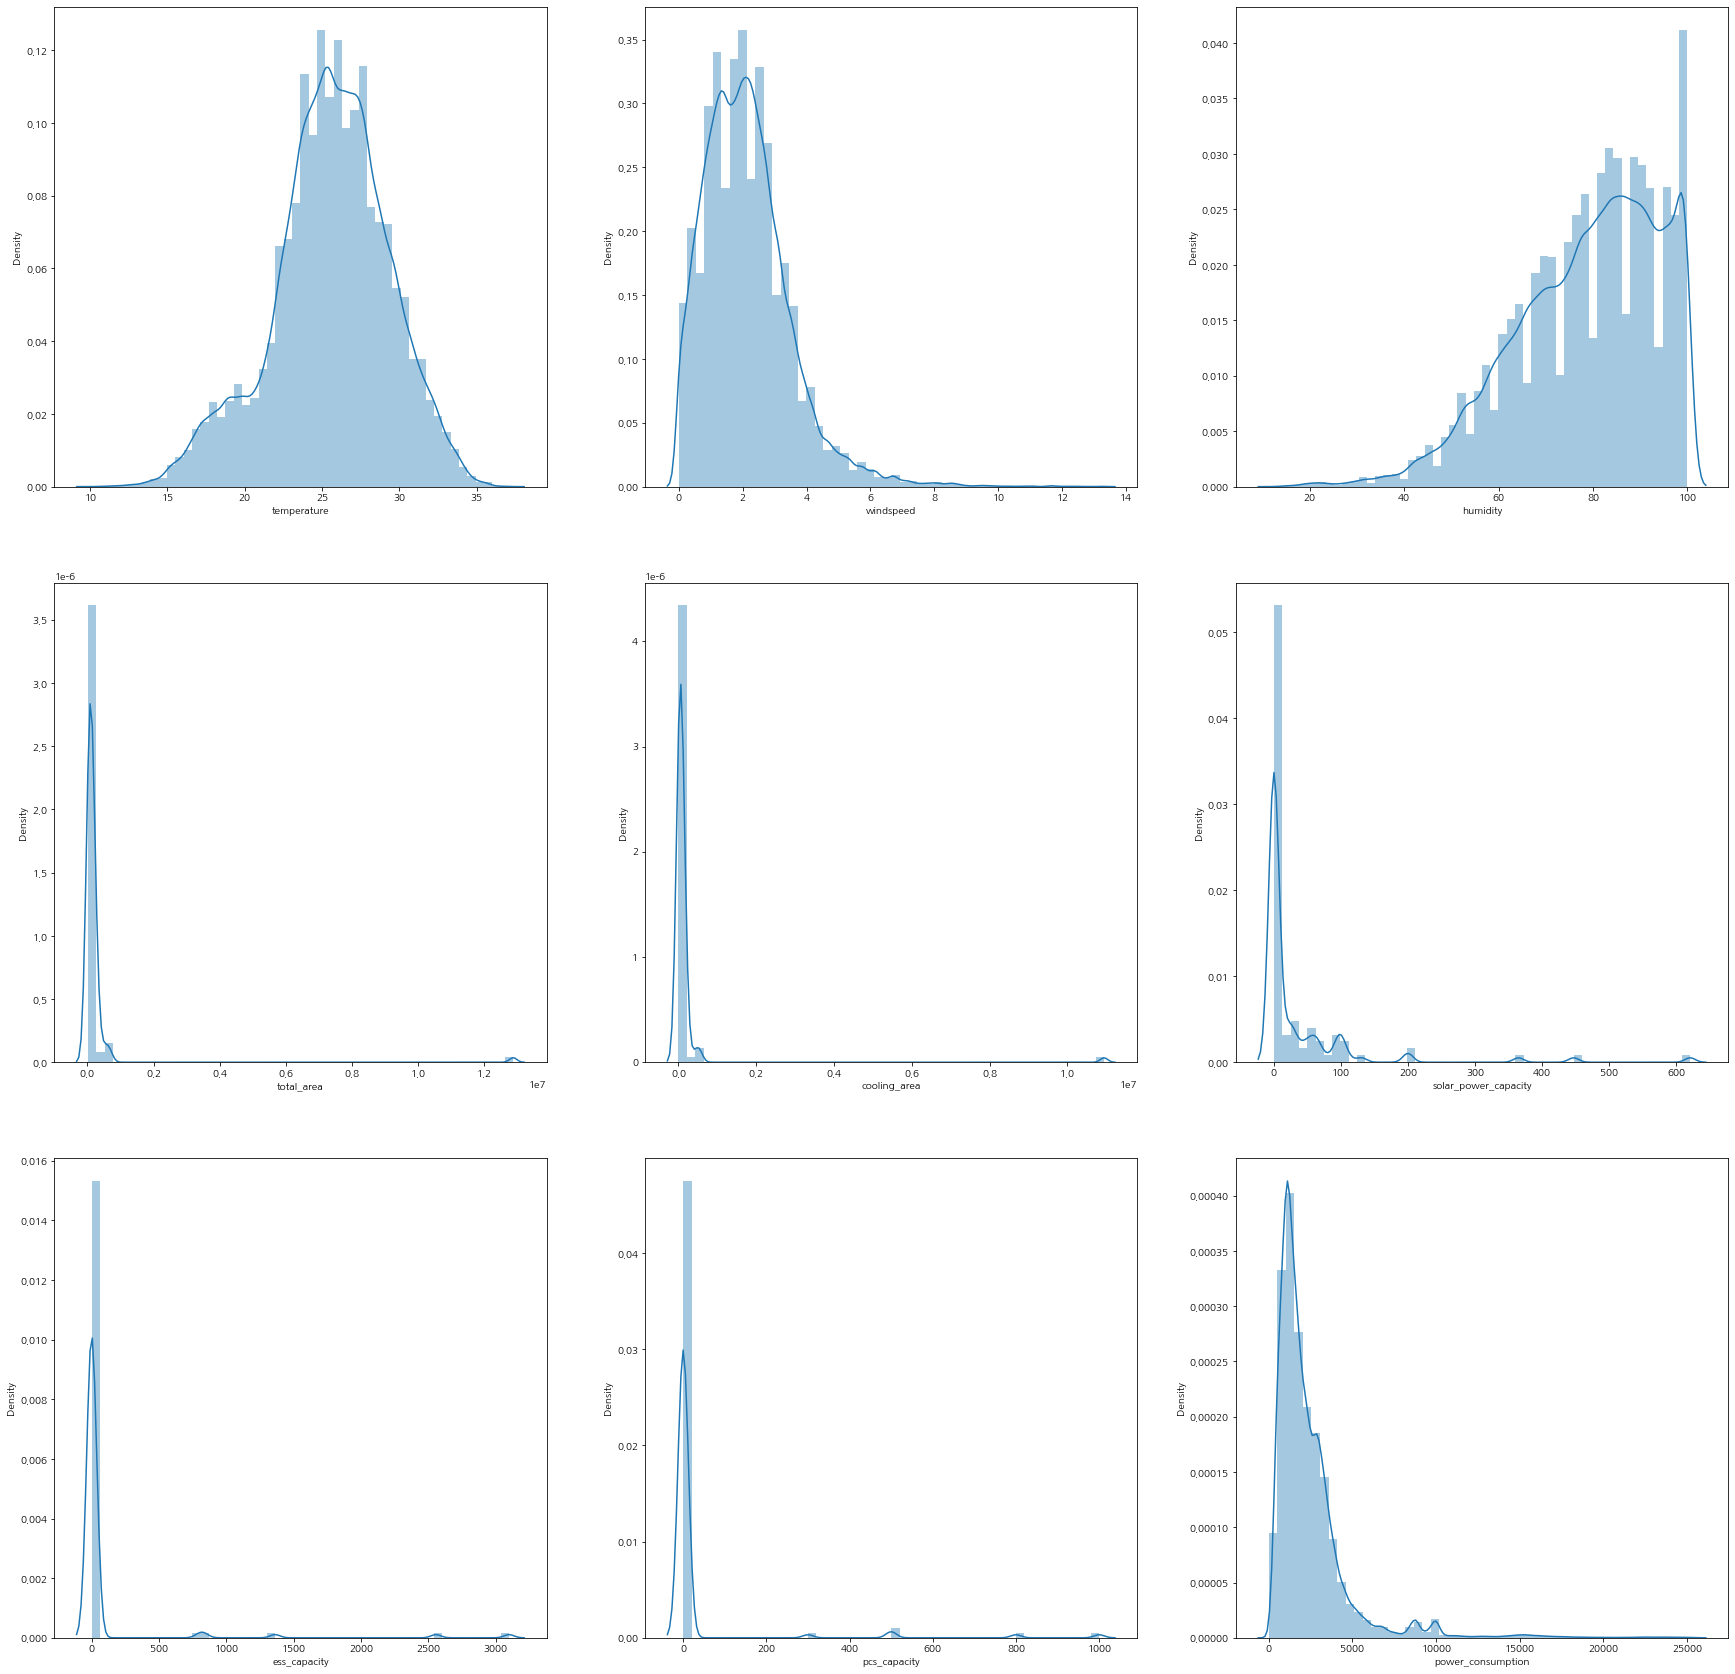

In [251]:
# fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(30,30))

# sns.distplot(train_df['temperature'], ax=ax[0,0])
# sns.distplot(train_df['windspeed'], ax=ax[0,1])
# sns.distplot(train_df['humidity'], ax=ax[0,2])
# sns.distplot(train_df['total_area'], ax=ax[1,0])
# sns.distplot(train_df['cooling_area'], ax=ax[1,1])
# sns.distplot(train_df['solar_power_capacity'], ax=ax[1,2])
# sns.distplot(train_df['ess_capacity'], ax=ax[2,0])
# sns.distplot(train_df['pcs_capacity'], ax=ax[2,1])
# sns.distplot(train_df['power_consumption'], ax=ax[2,2])

# 왜도, 첨도 확인

In [523]:
print(f'temperature 왜도 : {train_df.temperature.skew()}')
print(f'temperature 첨도: {train_df.temperature.kurt()}')
print(f'windspeed 왜도 : {train_df.windspeed.skew()}')
print(f'windspeed 첨도: {train_df.windspeed.kurt()}')
print(f'humidity 왜도 : {train_df.humidity.skew()}')
print(f'humidity 첨도: {train_df.humidity.kurt()}')
print(f'total_area 왜도 : {train_df.total_area.skew()}')
print(f'total_area 첨도: {train_df.total_area.kurt()}')
print(f'cooling_area 왜도 : {train_df.cooling_area.skew()}')
print(f'cooling_area 첨도: {train_df.cooling_area.kurt()}')
print(f'solar_power_capacity 왜도 : {train_df.solar_power_capacity.skew()}')
print(f'solar_power_capacity 첨도: {train_df.solar_power_capacity.kurt()}')
print(f'ess_capacity 왜도 : {train_df.ess_capacity.skew()}')
print(f'ess_capacity 첨도: {train_df.ess_capacity.kurt()}')
print(f'pcs_capacity 왜도 : {train_df.pcs_capacity.skew()}')
print(f'pcs_capacity 첨도: {train_df.pcs_capacity.kurt()}')
print(f'power_consumption 왜도 : {train_df.power_consumption.skew()}')
print(f'power_consumption 첨도: {train_df.power_consumption.kurt()}')

temperature 왜도 : -0.36503115207884607
temperature 첨도: 0.16547126155715963
windspeed 왜도 : 1.3363444823278392
windspeed 첨도: 4.079387019959593
humidity 왜도 : -0.7067982426042154
humidity 첨도: 0.16677253073591247
total_area 왜도 : 9.709987130014758
total_area 첨도: 93.17170019141228
cooling_area 왜도 : 9.73498107897056
cooling_area 첨도: 93.49583935860962
solar_power_capacity 왜도 : 4.3622322823781055
solar_power_capacity 첨도: 21.653908603654187
ess_capacity 왜도 : 5.641914994272193
ess_capacity 첨도: 32.552370942967194
pcs_capacity 왜도 : 5.092745996435079
pcs_capacity 첨도: 26.281561294173144
power_consumption 왜도 : 3.7427907369626885
power_consumption 첨도: 20.188483315083403


# 로그변환 진행 (total_area, cooling_area, solar_power_capacity, ess_capacity, pcs_capacity)

In [524]:
train_df['total_area'] = train_df['total_area'].map(lambda x:np.log(x) if x > 0 else 0)
train_df['cooling_area'] = train_df['cooling_area'].map(lambda x:np.log(x) if x > 0 else 0)
train_df['solar_power_capacity'] = train_df['solar_power_capacity'].map(lambda x:np.log(x) if x > 0 else 0)
train_df['ess_capacity'] = train_df['ess_capacity'].map(lambda x:np.log(x) if x > 0 else 0)
train_df['pcs_capacity'] = train_df['pcs_capacity'].map(lambda x:np.log(x) if x > 0 else 0)

test_df['total_area'] = test_df['total_area'].map(lambda x:np.log(x) if x > 0 else 0)
test_df['cooling_area'] = test_df['cooling_area'].map(lambda x:np.log(x) if x > 0 else 0)
test_df['solar_power_capacity'] = test_df['solar_power_capacity'].map(lambda x:np.log(x) if x > 0 else 0)
test_df['ess_capacity'] = test_df['ess_capacity'].map(lambda x:np.log(x) if x > 0 else 0)
test_df['pcs_capacity'] = test_df['pcs_capacity'].map(lambda x:np.log(x) if x > 0 else 0)

In [28]:
# # 년기준 일 평균 소비전력
# train_df['day_of_year'] = train_df['date_time'].dt.dayofyear
# mean_power_by_day_of_year = train_df.groupby('day_of_year')['power_consumption'].mean()
# # 년기준 시간평균 소비전력
# train_df['hour_of_year'] = train_df['date_time'].dt.hour + (train_df['date_time'].dt.dayofyear - 1) * 24
# mean_power_by_hour_of_year = train_df.groupby('hour_of_year')['power_consumption'].mean()

# # 년기준 월평균 소비전력
# mean_power_by_month = train_df.groupby('month')['power_consumption'].mean()

# # 일기준 시간 평균 소비전력
# mean_power_by_hour = train_df.groupby('hour')['power_consumption'].mean()

# # 월기준 시간 평균 소비전력
# mean_power_by_day = train_df.groupby('day')['power_consumption'].mean()

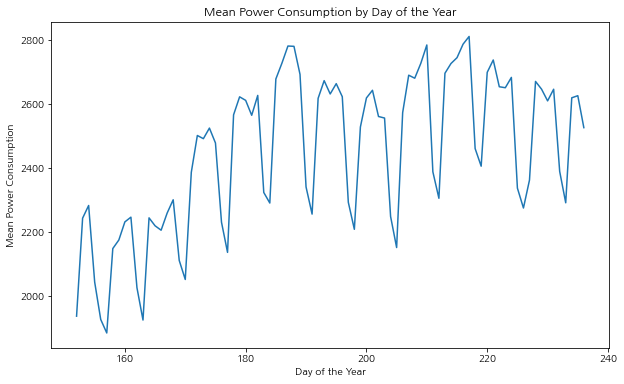

In [29]:
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=mean_power_by_day_of_year.index, y=mean_power_by_day_of_year.values)
# plt.title('Mean Power Consumption by Day of the Year')
# plt.xlabel('Day of the Year')
# plt.ylabel('Mean Power Consumption')
# plt.show()

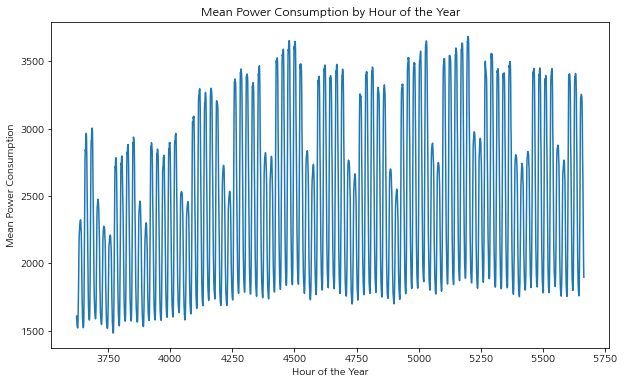

In [30]:
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=mean_power_by_hour_of_year.index, y=mean_power_by_hour_of_year.values)
# plt.title('Mean Power Consumption by Hour of the Year')
# plt.xlabel('Hour of the Year')
# plt.ylabel('Mean Power Consumption')
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=mean_power_by_hour_of_year.index, y=mean_power_by_hour_of_year.values)
# plt.title('Mean Power Consumption by Hour of the Year')
# plt.xlabel('Hour of the Year')
# plt.ylabel('Mean Power Consumption')
# plt.show()

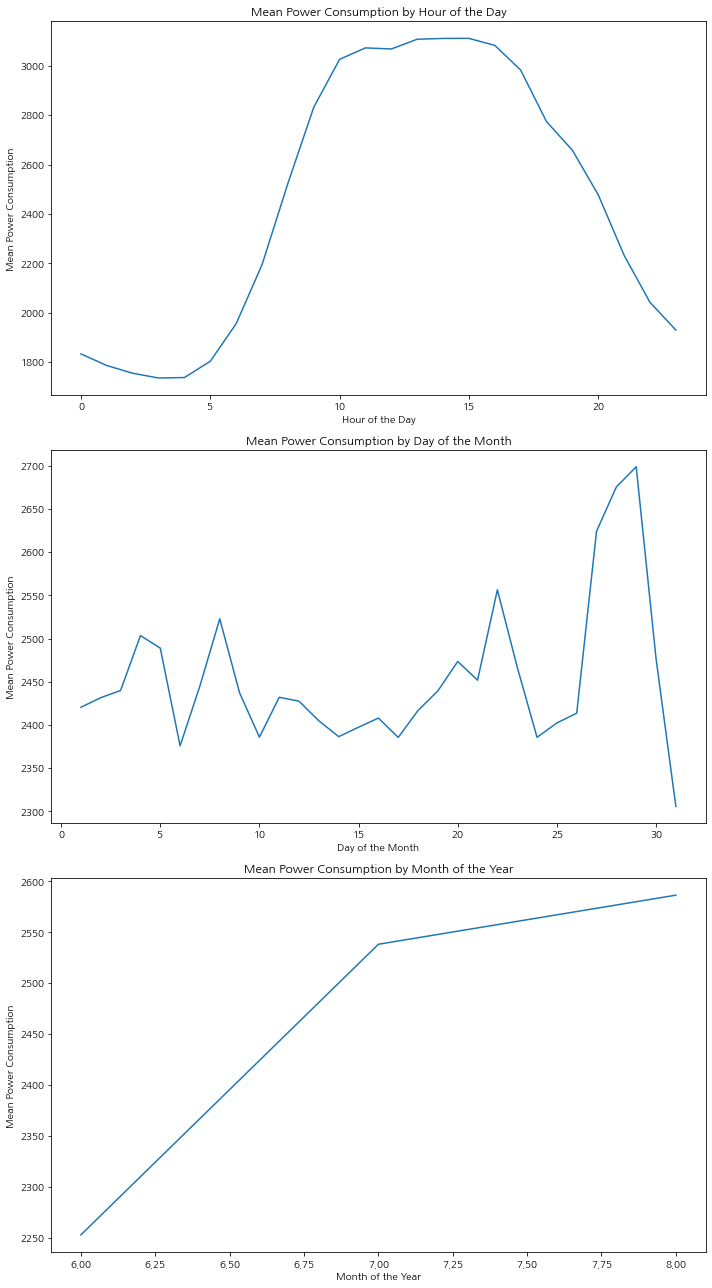

In [31]:
# fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# # Plot mean power consumption by hour of the day
# sns.lineplot(x=mean_power_by_hour.index, y=mean_power_by_hour.values, ax=axs[0])
# axs[0].set_title('Mean Power Consumption by Hour of the Day')
# axs[0].set_xlabel('Hour of the Day')
# axs[0].set_ylabel('Mean Power Consumption')

# # Plot mean power consumption by day of the month
# sns.lineplot(x=mean_power_by_day.index, y=mean_power_by_day.values, ax=axs[1])
# axs[1].set_title('Mean Power Consumption by Day of the Month')
# axs[1].set_xlabel('Day of the Month')
# axs[1].set_ylabel('Mean Power Consumption')

# # 년기준 월평균 소비전력
# sns.lineplot(x=mean_power_by_month.index, y=mean_power_by_month.values, ax=axs[2])
# axs[2].set_title('Mean Power Consumption by Month of the Year')
# axs[2].set_xlabel('Month of the Year')
# axs[2].set_ylabel('Mean Power Consumption')

# plt.tight_layout()
# plt.show()

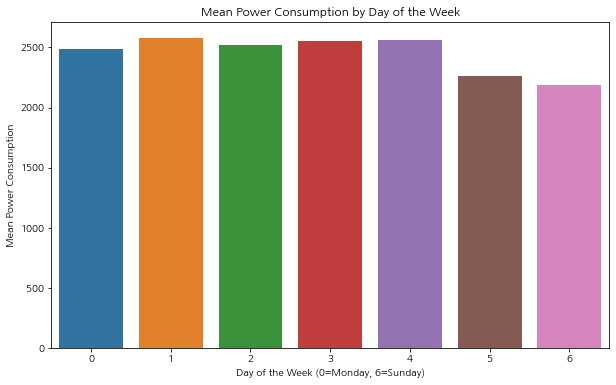

In [32]:
# train_df['day_of_week'] = train_df['date_time'].dt.dayofweek

# # 요일별 전력평균
# mean_power_by_day_of_week = train_df.groupby('day_of_week')['power_consumption'].mean()

# plt.figure(figsize=(10, 6))
# sns.barplot(x=mean_power_by_day_of_week.index, y=mean_power_by_day_of_week.values)
# plt.title('Mean Power Consumption by Day of the Week')
# plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
# plt.ylabel('Mean Power Consumption')
# plt.show()

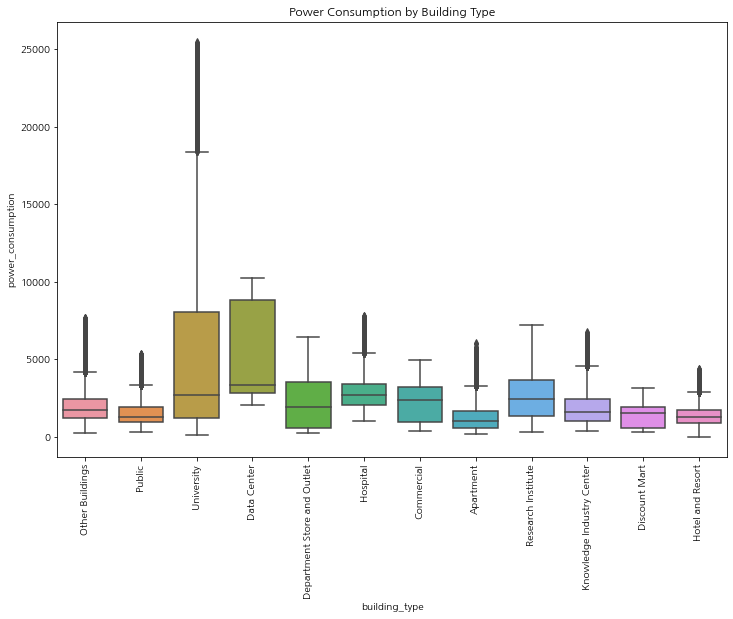

In [33]:
# plt.figure(figsize=(12, 8))
# sns.boxplot(x='building_type', y='power_consumption', data=train_df)
# plt.title('Power Consumption by Building Type')
# plt.xticks(rotation=90)
# plt.show()

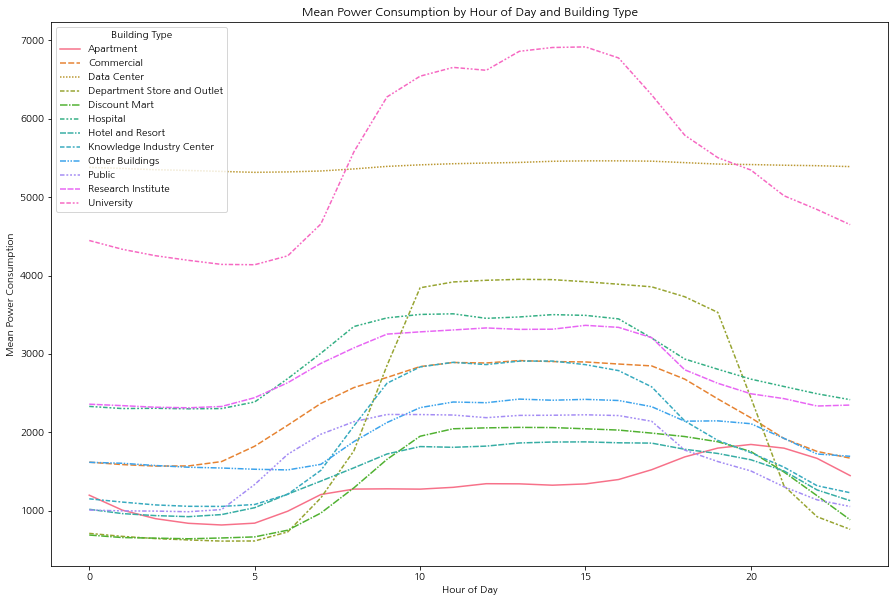

In [34]:
# mean_power_by_hour_building = train_df.groupby(['hour', 'building_type'])['power_consumption'].mean().reset_index()

# pivot_df = mean_power_by_hour_building.pivot(index='hour', columns='building_type', values='power_consumption')

# plt.figure(figsize=(15, 10))
# sns.lineplot(data=pivot_df)
# plt.title('Mean Power Consumption by Hour of Day and Building Type')
# plt.xlabel('Hour of Day')
# plt.ylabel('Mean Power Consumption')
# plt.legend(title='Building Type')
# plt.show()

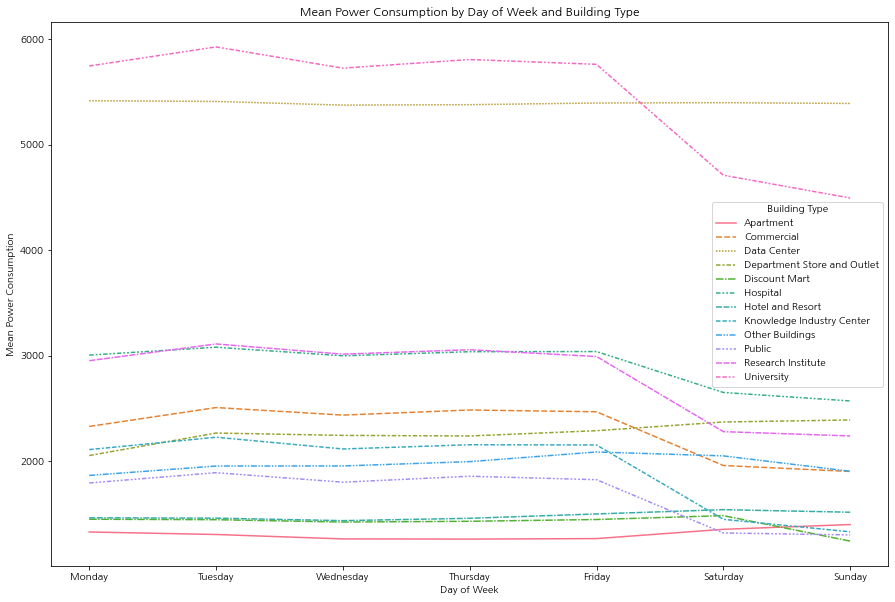

In [35]:
# mean_power_by_day_building = train_df.groupby(['day_of_week', 'building_type'])['power_consumption'].mean().reset_index()

# pivot_df_day = mean_power_by_day_building.pivot(index='day_of_week', columns='building_type', values='power_consumption')

# day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# pivot_df_day.index = day_names

# plt.figure(figsize=(15, 10))
# sns.lineplot(data=pivot_df_day)
# plt.title('Mean Power Consumption by Day of Week and Building Type')
# plt.xlabel('Day of Week')
# plt.ylabel('Mean Power Consumption')
# plt.legend(title='Building Type')
# plt.show()

C:\Users\magne\AppData\Local\Temp/ipykernel_12080/4172793230.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

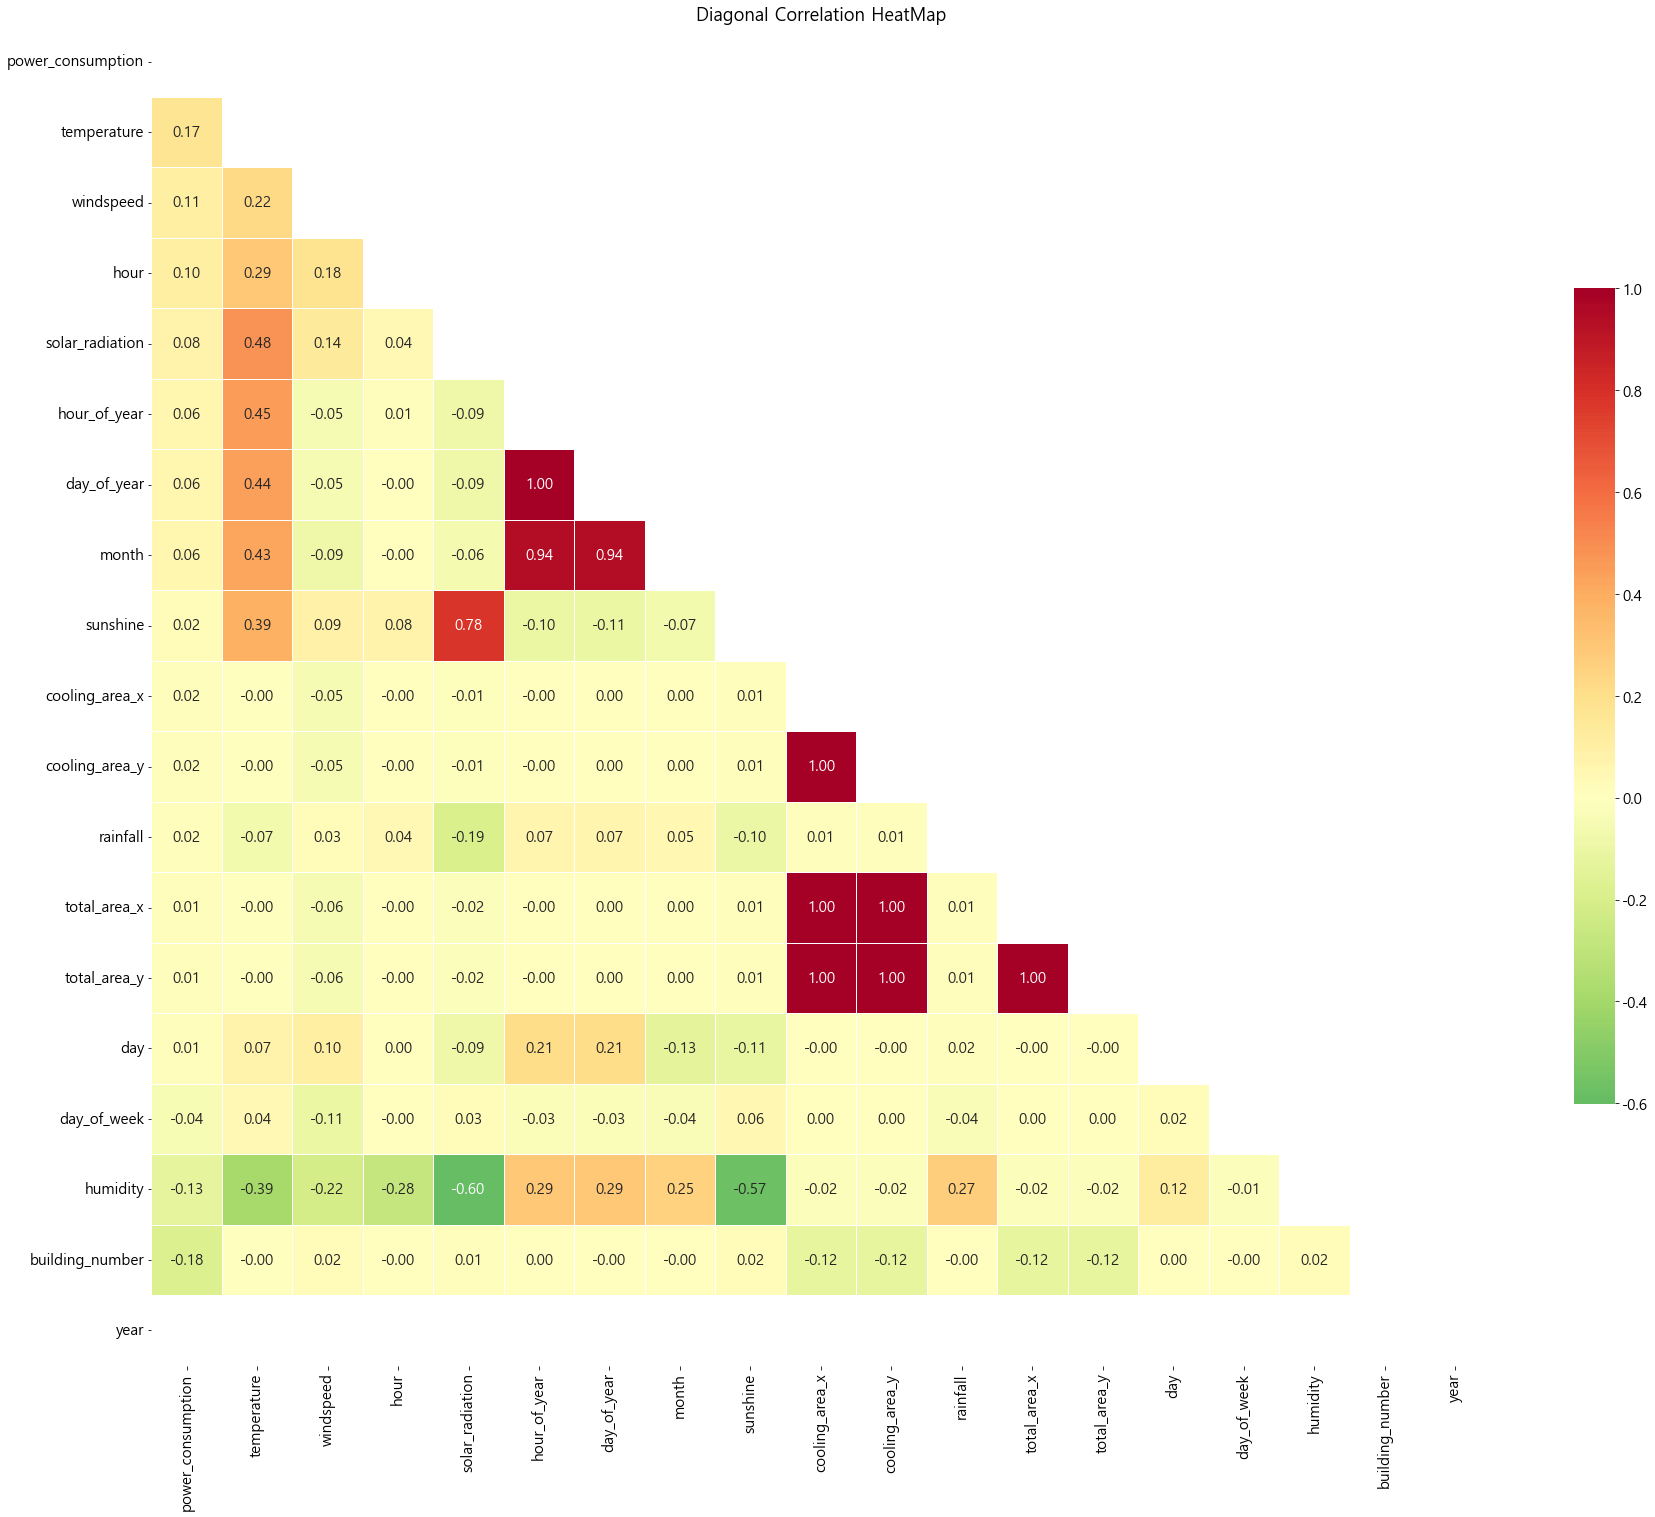

In [47]:
# plt.rc('font', family='Malgun Gothic')
# plt.rc('font', size=15)
# plt.rc('axes', unicode_minus=False)


# corr_matrix = train_df.corr()
# corr_matrix = corr_matrix.sort_values(by = 'power_consumption', axis = 0, ascending=False)
# corr_matrix = corr_matrix[corr_matrix.index]

# # 상관관계의 시각적 표현
# f, ax = plt.subplots(figsize=(30, 30))
# corr = train_df.select_dtypes(exclude=["object","bool"]).corr()

# # 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
# mask = np.zeros_like(corr_matrix, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
# center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.title("Diagonal Correlation HeatMap")

# 파생변수 생성

태양광, ESS 설치 여부 컬럼 생성 solar_no, ess_no  (0인경우 True)

불쾌지수 컬럼 생성 discomfort = 0.81 * temperature + 0.01 * humidity * (0.99 * temperature - 14.3) + 46.3

1, 2, 3 시간 전 기온, 풍속, 습도, 불쾌지수와의 차이 컬럼 생성

주말 및 공휴일 컬럼 생성 holiday

In [525]:
train_df['solar_no'] = train_df['solar_power_capacity']==0
print(len(train_df[train_df['solar_no']==True]))

test_df['solar_no'] = test_df['solar_power_capacity']==0
print(len(test_df[test_df['solar_no']==True]))

130547
10752


In [526]:
train_df['ess_no'] = train_df['ess_capacity']==0
print(len(train_df[train_df['ess_no']==True]))

test_df['ess_no'] = test_df['ess_capacity']==0
print(len(test_df[test_df['ess_no']==True]))

193781
15960


In [527]:
train_df.head(1)

,building_number,date_time,temperature,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,hour,day,month,solar_no,ess_no
0,1,2022-06-01,18.6,0.9,42.0,1085.28,Other Buildings,11.613983,10.585827,0.0,0.0,0.0,0,1,6,True,True


In [528]:
train_df['discomfort'] = 0.81 * train_df['temperature'] + 0.01 * train_df['humidity'] * (0.99 * train_df['temperature'] - 14.3) + 46.3
test_df['discomfort'] = 0.81 * test_df['temperature'] + 0.01 * test_df['humidity'] * (0.99 * test_df['temperature'] - 14.3) + 46.3

train_df['discomfort']

0         63.09388
1         62.46400
2         62.08735
3         60.89884
4         62.88788
            ...   
203995    72.38034
203996    71.21736
203997    69.79704
203998    69.41060
203999    68.95035
Name: discomfort, Length: 203981, dtype: float64

In [529]:
train_df.nunique()

building_number           100
date_time                2040
temperature               263
windspeed                 120
humidity                  101
power_consumption       51810
building_type              12
total_area                100
cooling_area               97
solar_power_capacity       33
ess_capacity                6
pcs_capacity                5
hour                       24
day                        31
month                       3
solar_no                    2
ess_no                      2
discomfort               9610
dtype: int64

In [530]:
train_df['temperature_1'] = train_df.groupby('building_number')['temperature'].shift()
train_df['temperature_1'] = train_df[train_df['temperature_1'] != 0]['temperature'] - train_df[train_df['temperature_1'] != 0]['temperature_1']
train_df['temperature_1'] = train_df['temperature_1'].fillna(0)
train_df['temperature_2'] = train_df.groupby('building_number')['temperature'].shift(periods=2)
train_df['temperature_2'] = train_df[train_df['temperature_2'] != 0]['temperature'] - train_df[train_df['temperature_2'] != 0]['temperature_2']
train_df['temperature_2'] = train_df['temperature_2'].fillna(0)
train_df['temperature_3'] = train_df.groupby('building_number')['temperature'].shift(periods=3)
train_df['temperature_3'] = train_df[train_df['temperature_3'] != 0]['temperature'] - train_df[train_df['temperature_3'] != 0]['temperature_3']
train_df['temperature_3'] = train_df['temperature_3'].fillna(0)

train_df.head()

,building_number,date_time,temperature,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,...,pcs_capacity,hour,day,month,solar_no,ess_no,discomfort,temperature_1,temperature_2,temperature_3
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,Other Buildings,11.613983,10.585827,0.0,...,0.0,0,1,6,True,True,63.09388,0.0,0.0,0.0
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,Other Buildings,11.613983,10.585827,0.0,...,0.0,1,1,6,True,True,62.46400,-0.6,0.0,0.0
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,Other Buildings,11.613983,10.585827,0.0,...,0.0,2,1,6,True,True,62.08735,-0.3,-0.9,0.0
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,Other Buildings,11.613983,10.585827,0.0,...,0.0,3,1,6,True,True,60.89884,-1.0,-1.3,-1.9
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,Other Buildings,11.613983,10.585827,0.0,...,0.0,4,1,6,True,True,62.88788,1.7,0.7,0.4


In [531]:
train_df['windspeed_1'] = train_df.groupby('building_number')['windspeed'].shift()
train_df['windspeed_1'] = train_df[train_df['windspeed_1'] != 0]['windspeed'] - train_df[train_df['windspeed_1'] != 0]['windspeed_1']
train_df['windspeed_1'] = train_df['windspeed_1'].fillna(0)
train_df['windspeed_2'] = train_df.groupby('building_number')['windspeed'].shift(periods=2)
train_df['windspeed_2'] = train_df[train_df['windspeed_2'] != 0]['windspeed'] - train_df[train_df['windspeed_2'] != 0]['windspeed_2']
train_df['windspeed_2'] = train_df['windspeed_2'].fillna(0)
train_df['windspeed_3'] = train_df.groupby('building_number')['windspeed'].shift(periods=3)
train_df['windspeed_3'] = train_df[train_df['windspeed_3'] != 0]['windspeed'] - train_df[train_df['windspeed_3'] != 0]['windspeed_3']
train_df['windspeed_3'] = train_df['windspeed_3'].fillna(0)

train_df['humidity_1'] = train_df.groupby('building_number')['humidity'].shift()
train_df['humidity_1'] = train_df[train_df['humidity_1'] != 0]['humidity'] - train_df[train_df['humidity_1'] != 0]['humidity_1']
train_df['humidity_1'] = train_df['humidity_1'].fillna(0)
train_df['humidity_2'] = train_df.groupby('building_number')['humidity'].shift(periods=2)
train_df['humidity_2'] = train_df[train_df['humidity_2'] != 0]['humidity'] - train_df[train_df['humidity_2'] != 0]['humidity_2']
train_df['humidity_2'] = train_df['humidity_2'].fillna(0)
train_df['humidity_3'] = train_df.groupby('building_number')['humidity'].shift(periods=3)
train_df['humidity_3'] = train_df[train_df['humidity_3'] != 0]['humidity'] - train_df[train_df['humidity_2'] != 0]['humidity_3']
train_df['humidity_3'] = train_df['humidity_3'].fillna(0)

train_df['discomfort_1'] = train_df.groupby('building_number')['discomfort'].shift()
train_df['discomfort_1'] = train_df[train_df['discomfort_1'] != 0]['discomfort'] - train_df[train_df['discomfort_1'] != 0]['discomfort_1']
train_df['discomfort_1'] = train_df['discomfort_1'].fillna(0)
train_df['discomfort_2'] = train_df.groupby('building_number')['discomfort'].shift(periods=2)
train_df['discomfort_2'] = train_df[train_df['discomfort_2'] != 0]['discomfort'] - train_df[train_df['discomfort_2'] != 0]['discomfort_2']
train_df['discomfort_2'] = train_df['discomfort_2'].fillna(0)
train_df['discomfort_3'] = train_df.groupby('building_number')['discomfort'].shift(periods=3)
train_df['discomfort_3'] = train_df[train_df['discomfort_3'] != 0]['discomfort'] - train_df[train_df['discomfort_3'] != 0]['discomfort_3']
train_df['discomfort_3'] = train_df['discomfort_3'].fillna(0)

train_df.head()

,building_number,date_time,temperature,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,...,temperature_3,windspeed_1,windspeed_2,windspeed_3,humidity_1,humidity_2,humidity_3,discomfort_1,discomfort_2,discomfort_3
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,Other Buildings,11.613983,10.585827,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,Other Buildings,11.613983,10.585827,0.0,...,0.0,0.2,0.0,0.0,3.0,0.0,0.0,-0.62988,0.00000,0.00000
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,Other Buildings,11.613983,10.585827,0.0,...,0.0,0.4,0.6,0.0,0.0,3.0,0.0,-0.37665,-1.00653,0.00000
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,Other Buildings,11.613983,10.585827,0.0,...,-1.9,-0.1,0.3,0.5,3.0,3.0,6.0,-1.18851,-1.56516,-2.19504
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,Other Buildings,11.613983,10.585827,0.0,...,0.4,1.4,1.3,1.7,-5.0,-2.0,-2.0,1.98904,0.80053,0.42388


In [532]:
test_df['temperature_1'] = test_df.groupby('building_number')['temperature'].shift()
test_df['temperature_1'] = test_df[test_df['temperature_1'] != 0]['temperature'] - test_df[test_df['temperature_1'] != 0]['temperature_1']
test_df['temperature_1'] = test_df['temperature_1'].fillna(0)
test_df['temperature_2'] = test_df.groupby('building_number')['temperature'].shift(periods=2)
test_df['temperature_2'] = test_df[test_df['temperature_2'] != 0]['temperature'] - test_df[test_df['temperature_2'] != 0]['temperature_2']
test_df['temperature_2'] = test_df['temperature_2'].fillna(0)
test_df['temperature_3'] = test_df.groupby('building_number')['temperature'].shift(periods=3)
test_df['temperature_3'] = test_df[test_df['temperature_3'] != 0]['temperature'] - test_df[test_df['temperature_3'] != 0]['temperature_3']
test_df['temperature_3'] = test_df['temperature_3'].fillna(0)

test_df['windspeed_1'] = test_df.groupby('building_number')['windspeed'].shift()
test_df['windspeed_1'] = test_df[test_df['windspeed_1'] != 0]['windspeed'] - test_df[test_df['windspeed_1'] != 0]['windspeed_1']
test_df['windspeed_1'] = test_df['windspeed_1'].fillna(0)
test_df['windspeed_2'] = test_df.groupby('building_number')['windspeed'].shift(periods=2)
test_df['windspeed_2'] = test_df[test_df['windspeed_2'] != 0]['windspeed'] - test_df[test_df['windspeed_2'] != 0]['windspeed_2']
test_df['windspeed_2'] = test_df['windspeed_2'].fillna(0)
test_df['windspeed_3'] = test_df.groupby('building_number')['windspeed'].shift(periods=3)
test_df['windspeed_3'] = test_df[test_df['windspeed_3'] != 0]['windspeed'] - test_df[test_df['windspeed_3'] != 0]['windspeed_3']
test_df['windspeed_3'] = test_df['windspeed_3'].fillna(0)

test_df['humidity_1'] = test_df.groupby('building_number')['humidity'].shift()
test_df['humidity_1'] = test_df[test_df['humidity_1'] != 0]['humidity'] - test_df[test_df['humidity_1'] != 0]['humidity_1']
test_df['humidity_1'] = test_df['humidity_1'].fillna(0)
test_df['humidity_2'] = test_df.groupby('building_number')['humidity'].shift(periods=2)
test_df['humidity_2'] = test_df[test_df['humidity_2'] != 0]['humidity'] - test_df[test_df['humidity_2'] != 0]['humidity_2']
test_df['humidity_2'] = test_df['humidity_2'].fillna(0)
test_df['humidity_3'] = test_df.groupby('building_number')['humidity'].shift(periods=3)
test_df['humidity_3'] = test_df[test_df['humidity_3'] != 0]['humidity'] - test_df[test_df['humidity_2'] != 0]['humidity_3']
test_df['humidity_3'] = test_df['humidity_3'].fillna(0)

test_df['discomfort_1'] = test_df.groupby('building_number')['discomfort'].shift()
test_df['discomfort_1'] = test_df[test_df['discomfort_1'] != 0]['discomfort'] - test_df[test_df['discomfort_1'] != 0]['discomfort_1']
test_df['discomfort_1'] = test_df['discomfort_1'].fillna(0)
test_df['discomfort_2'] = test_df.groupby('building_number')['discomfort'].shift(periods=2)
test_df['discomfort_2'] = test_df[test_df['discomfort_2'] != 0]['discomfort'] - test_df[test_df['discomfort_2'] != 0]['discomfort_2']
test_df['discomfort_2'] = test_df['discomfort_2'].fillna(0)
test_df['discomfort_3'] = test_df.groupby('building_number')['discomfort'].shift(periods=3)
test_df['discomfort_3'] = test_df[test_df['discomfort_3'] != 0]['discomfort'] - test_df[test_df['discomfort_3'] != 0]['discomfort_3']
test_df['discomfort_3'] = test_df['discomfort_3'].fillna(0)

test_df.head()

,building_number,date_time,temperature,windspeed,humidity,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,...,temperature_3,windspeed_1,windspeed_2,windspeed_3,humidity_1,humidity_2,humidity_3,discomfort_1,discomfort_2,discomfort_3
0,1,2022-08-25 00:00:00,23.5,2.2,72,Other Buildings,11.613983,10.585827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000
1,1,2022-08-25 01:00:00,23.0,0.9,72,Other Buildings,11.613983,10.585827,0.0,0.0,...,0.0,-1.3,0.0,0.0,0.0,0.0,0.0,-0.76140,0.00000,0.00000
2,1,2022-08-25 02:00:00,22.7,1.5,75,Other Buildings,11.613983,10.585827,0.0,0.0,...,0.0,0.6,-0.7,0.0,3.0,3.0,0.0,-0.21165,-0.97305,0.00000
3,1,2022-08-25 03:00:00,22.1,1.3,78,Other Buildings,11.613983,10.585827,0.0,0.0,...,-1.4,-0.2,0.4,-0.9,3.0,6.0,6.0,-0.70413,-0.91578,-1.67718
4,1,2022-08-25 04:00:00,21.8,1.0,77,Other Buildings,11.613983,10.585827,0.0,0.0,...,-1.2,-0.3,-0.5,0.1,-1.0,2.0,5.0,-0.54748,-1.25161,-1.46326


In [533]:
train_df['holiday'] = train_df['date_time'].dt.dayofweek
train_df = train_df.drop('date_time',axis=1)

test_df['holiday'] = test_df['date_time'].dt.dayofweek
test_df = test_df.drop('date_time',axis=1)

In [534]:
train_df.loc[(train_df['month']==6)&(train_df['day']==6), 'holiday'] = 7
train_df.loc[(train_df['month']==8)&(train_df['day']==15), 'holiday'] = 7
print(len(train_df[train_df.holiday==7]))

4800


In [535]:
train_df['holiday'].value_counts()

2    31198
4    28800
1    28799
6    28798
3    28795
5    28792
0    23999
7     4800
Name: holiday, dtype: int64

In [536]:
test_df['holiday'].value_counts()

3    2400
4    2400
5    2400
6    2400
0    2400
1    2400
2    2400
Name: holiday, dtype: int64

In [537]:
train_df['holiday'] = train_df['holiday'].map({5: True, 6: True, 7: True}).fillna(False)

# 결과 확인
print(train_df['holiday'].value_counts())

test_df['holiday'] = test_df['holiday'].map({5: True, 6: True, 7: True}).fillna(False)

# 결과 확인
print(test_df['holiday'].value_counts())

False    141591
True      62390
Name: holiday, dtype: int64
False    12000
True      4800
Name: holiday, dtype: int64


In [538]:
train_df.head()

,building_number,temperature,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,...,windspeed_1,windspeed_2,windspeed_3,humidity_1,humidity_2,humidity_3,discomfort_1,discomfort_2,discomfort_3,holiday
0,1,18.6,0.9,42.0,1085.28,Other Buildings,11.613983,10.585827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,False
1,1,18.0,1.1,45.0,1047.36,Other Buildings,11.613983,10.585827,0.0,0.0,...,0.2,0.0,0.0,3.0,0.0,0.0,-0.62988,0.00000,0.00000,False
2,1,17.7,1.5,45.0,974.88,Other Buildings,11.613983,10.585827,0.0,0.0,...,0.4,0.6,0.0,0.0,3.0,0.0,-0.37665,-1.00653,0.00000,False
3,1,16.7,1.4,48.0,953.76,Other Buildings,11.613983,10.585827,0.0,0.0,...,-0.1,0.3,0.5,3.0,3.0,6.0,-1.18851,-1.56516,-2.19504,False
4,1,18.4,2.8,43.0,986.40,Other Buildings,11.613983,10.585827,0.0,0.0,...,1.4,1.3,1.7,-5.0,-2.0,-2.0,1.98904,0.80053,0.42388,False


In [539]:
test_df.head()

,building_number,temperature,windspeed,humidity,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,...,windspeed_1,windspeed_2,windspeed_3,humidity_1,humidity_2,humidity_3,discomfort_1,discomfort_2,discomfort_3,holiday
0,1,23.5,2.2,72,Other Buildings,11.613983,10.585827,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,False
1,1,23.0,0.9,72,Other Buildings,11.613983,10.585827,0.0,0.0,0.0,...,-1.3,0.0,0.0,0.0,0.0,0.0,-0.76140,0.00000,0.00000,False
2,1,22.7,1.5,75,Other Buildings,11.613983,10.585827,0.0,0.0,0.0,...,0.6,-0.7,0.0,3.0,3.0,0.0,-0.21165,-0.97305,0.00000,False
3,1,22.1,1.3,78,Other Buildings,11.613983,10.585827,0.0,0.0,0.0,...,-0.2,0.4,-0.9,3.0,6.0,6.0,-0.70413,-0.91578,-1.67718,False
4,1,21.8,1.0,77,Other Buildings,11.613983,10.585827,0.0,0.0,0.0,...,-0.3,-0.5,0.1,-1.0,2.0,5.0,-0.54748,-1.25161,-1.46326,False


In [540]:
train_df.to_csv('./data/pp_train.csv', encoding='utf-8', index=False)
test_df.to_csv('./data/pp_test.csv', encoding='utf-8', index=False)